In [1]:
#generales
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import scipy.stats as stats

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

import time
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
#configuraciones generales
pd.set_option('display.max_columns', None)

In [54]:
# generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# preprocesamiento y evaluacion
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, cohen_kappa_score, roc_curve, ConfusionMatrixDisplay, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.calibration import calibration_curve

# modelado
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as rf
import lightgbm as lgb
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV



# Verificación de la correcta carga del dataset

In [3]:
#carga de los datos
df = pd.read_csv("./dataset/data_final.csv")

#cantidad de elementos en el dataset
print(df.shape)

(100000, 57)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  int64  
 1   sub_status                100000 non-null  int64  
 2   condition                 100000 non-null  int64  
 3   seller_id                 100000 non-null  int64  
 4   price                     100000 non-null  float64
 5   attributes                100000 non-null  int64  
 6   buying_mode               100000 non-null  int64  
 7   tags                      100000 non-null  int64  
 8   category_id               100000 non-null  int64  
 9   pictures                  100000 non-null  int64  
 10  official_store_id         100000 non-null  int64  
 11  accepts_mercadopago       100000 non-null  bool   
 12  currency_id               100000 non-null  int64  
 13  automatic_relist          100000 non-null  bo

In [5]:
dtypes = df.dtypes 
cat_columns = dtypes[dtypes == 'object'].count()
print(f"Cant. features no numéricos: {cat_columns}")

Cant. features no numéricos: 2


In [6]:
print(df['other'].value_counts())
print(df['df_ship_methods'].value_counts())

other
False    65905
0        30559
True      3536
Name: count, dtype: int64
df_ship_methods
0       96994
True     3006
Name: count, dtype: int64


In [7]:
df['other'] = df['other'].map({'False': 0, 'True': 1, '0': 0})
df['df_ship_methods'] = df['df_ship_methods'].map({'0': 0, 'True': 1})

In [8]:
print(df['other'].value_counts())
print(df['df_ship_methods'].value_counts())

other
0    96464
1     3536
Name: count, dtype: int64
df_ship_methods
0    96994
1     3006
Name: count, dtype: int64


# Definición del baseline y selección del modelo a utilizar

## Baseline 1

In [9]:
X = df.drop(columns='condition')
y = df['condition']

In [10]:
# Se separa el conjunto de entrenamiento y testeo en 75% y 25% respectivamente.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1234)

In [11]:
# Opción 1 de baseline: Predice siempre que es usado
y_pred_baseline1_test = np.array([1] * len(y_test))

In [12]:
# Se escalan los datos
sc_X = MinMaxScaler()

X_train = sc_X.fit_transform(X_train) 
X_test = sc_X.transform(X_test)

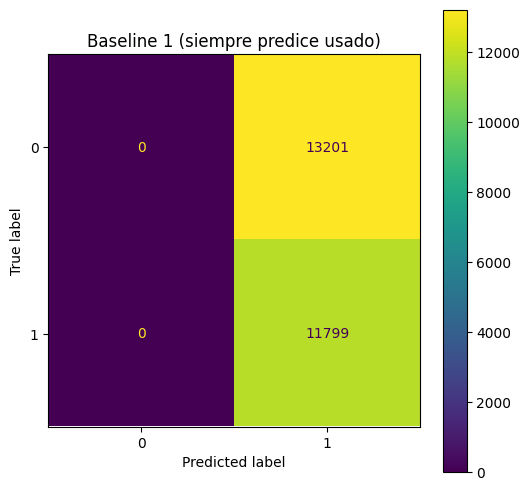

In [13]:
cm_baseline1 = confusion_matrix(y_test, y_pred_baseline1_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline1)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Baseline 1 (siempre predice usado)");

In [14]:
def model_stats(modelname, confusion_matrix, y_test, y_pred):
    print(f"Estadisticas para el modelo: {modelname}")
    P = np.sum(confusion_matrix[1, :])
    N = np.sum(confusion_matrix[0, :])
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    TPR = TP/P
    TNR = TN/N
    print(f"Sensibilidad: {TP/P}")
    print(f"Especificidad: {TN/N}")
    print(f"Exactitud balanceada: {(TPR + TNR)/2}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
    print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
    print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"======================")

In [15]:
# Se evalúan métricas para el modelo base
model_stats("Baseline 1", cm_baseline1, y_test, y_pred_baseline1_test)

Estadisticas para el modelo: Baseline 1
Sensibilidad: 1.0
Especificidad: 0.0
Exactitud balanceada: 0.5
Precision: 0.47196
Recuperación: 1.0
F1-score: 0.6412674257452649
Accuracy: 0.47196


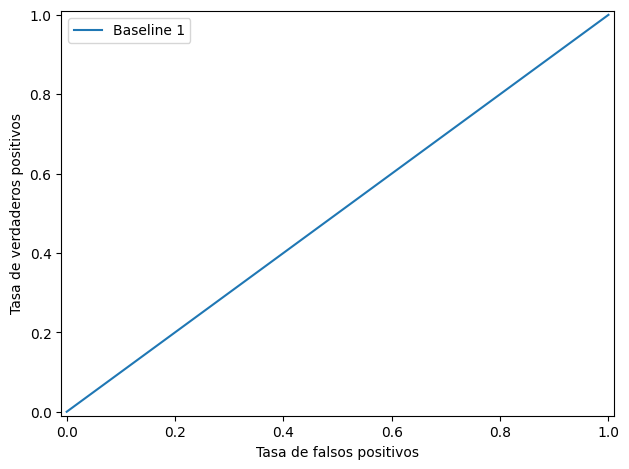

In [16]:
fpr_baseline1, tpr_baseline1, _ = roc_curve(y_test, y_pred_baseline1_test)

plt.plot(fpr_baseline1, tpr_baseline1, label="Baseline 1")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout()

In [17]:
print(f"AUC (baseline 1): {auc(fpr_baseline1, tpr_baseline1)}")

AUC (baseline 1): 0.5


In [18]:
'''
# correlación seaborn entre variables numéricas
plt.figure(figsize=(18,18))
features_list = list(df.columns.values)
features_list.remove("condition")
corr = df[features_list].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,annot=True, cmap='YlOrRd', fmt=".2f", cbar_kws={'label': 'Correlación'})
plt.show()
'''

'\n# correlación seaborn entre variables numéricas\nplt.figure(figsize=(18,18))\nfeatures_list = list(df.columns.values)\nfeatures_list.remove("condition")\ncorr = df[features_list].corr()\nmask = np.triu(np.ones_like(corr, dtype=bool))\nsns.heatmap(corr, mask=mask,annot=True, cmap=\'YlOrRd\', fmt=".2f", cbar_kws={\'label\': \'Correlación\'})\nplt.show()\n'

## Baseline 2

In [19]:
# Función para ejecutar y evaluar el modelo
def run_model(model, X_train, y_train, X_test, y_test, modelname):
    start_time = time.time()
    model.fit(X_train, y_train)

    time_taken_train = time.time() - start_time
    start_time = time.time()

    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    time_taken_predict = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, probs)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    

    # Plot ROC curve
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    # Plot Confusion Matrix
    if modelname == "XGB":
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
    else:
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

    matrix = confusion_matrix(y_test, y_pred)

    model_stats(modelname, matrix, y_test, y_pred)

    return model, accuracy, roc_auc, coh_kap, time_taken_train, time_taken_predict

# Función para graficar la curva ROC
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

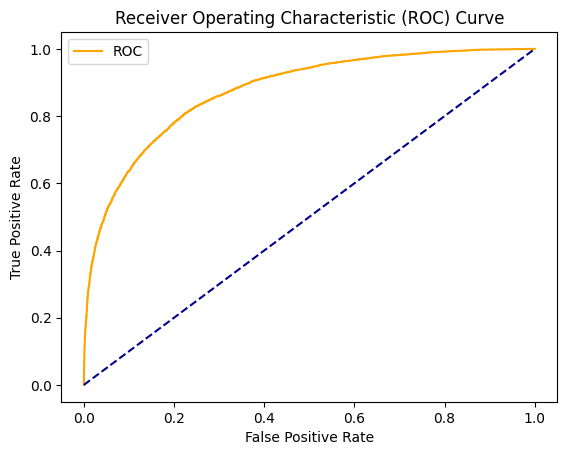

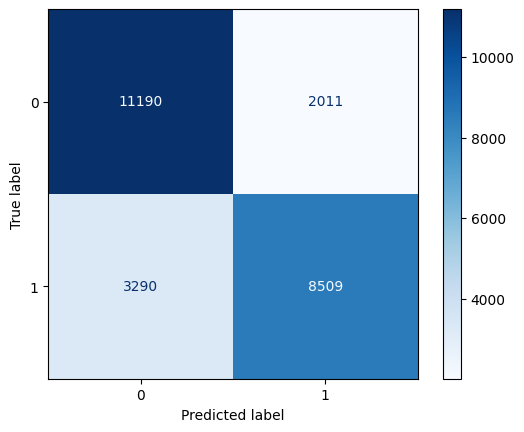

Estadisticas para el modelo: Regresion Logistica
Sensibilidad: 0.7211628104076616
Especificidad: 0.8476630558291038
Exactitud balanceada: 0.7844129331183827
Precision: 0.8088403041825095
Recuperación: 0.7211628104076616
F1-score: 0.7624893588422421
Accuracy: 0.78796


In [20]:
params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, ttt_lr , ttp_lr = run_model(model_lr, X_train, y_train, X_test, y_test, "Regresion Logistica")

## Árbol de desición

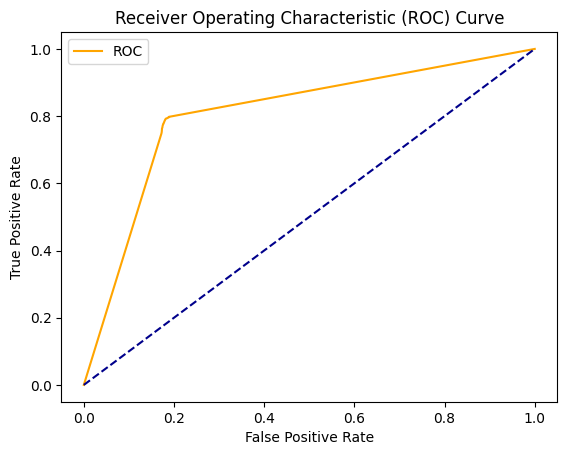

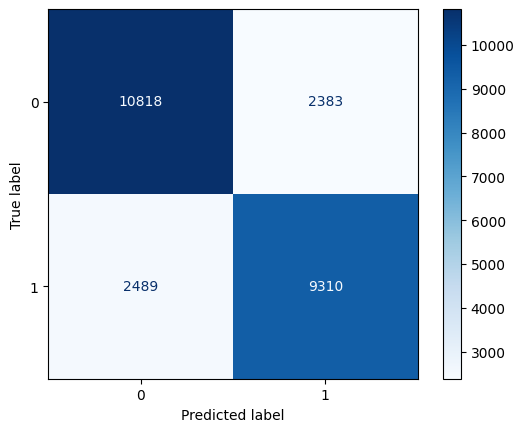

Estadisticas para el modelo: Arbol de desición
Sensibilidad: 0.789049919484702
Especificidad: 0.8194833724717825
Exactitud balanceada: 0.8042666459782423
Precision: 0.7962028564098178
Recuperación: 0.789049919484702
F1-score: 0.7926102502979737
Accuracy: 0.80512


In [21]:
params_dt = {'max_depth': 30,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, ttt_dt , ttp_dt = run_model(model_dt, X_train, y_train, X_test, y_test, "Arbol de desición")

### Random Forest

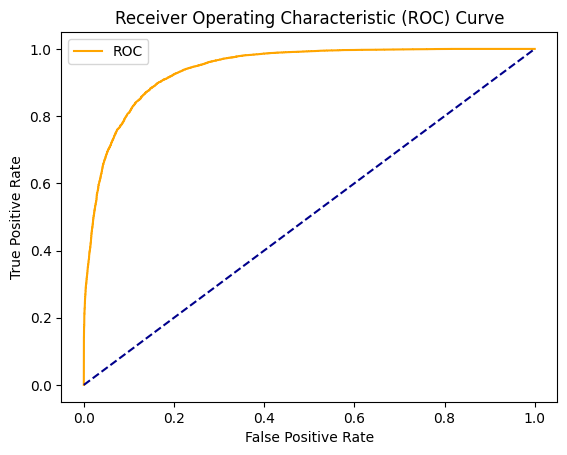

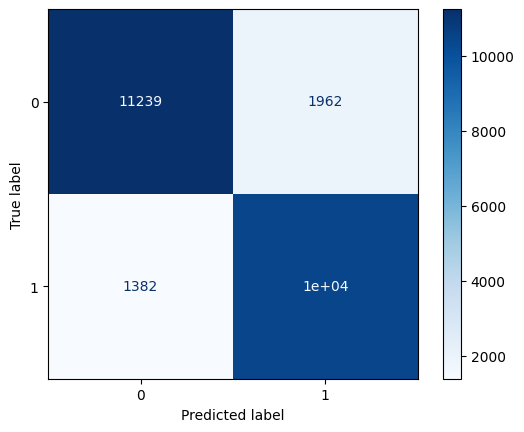

Estadisticas para el modelo: Random Forest
Sensibilidad: 0.8828714297821849
Especificidad: 0.8513748958412242
Exactitud balanceada: 0.8671231628117045
Precision: 0.8415057759108167
Recuperación: 0.8828714297821849
F1-score: 0.8616924476797088
Accuracy: 0.86624


In [22]:
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 500,
             'random_state': 12345}

model_rf = rf(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, ttt_rf , ttp_rf = run_model(model_rf, X_train, y_train, X_test, y_test, "Random Forest")

### LGBMClassifier
Árbol de desición de LGBM

[LightGBM] [Info] Number of positive: 34443, number of negative: 40557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459240 -> initscore=-0.163403
[LightGBM] [Info] Start training from score -0.163403


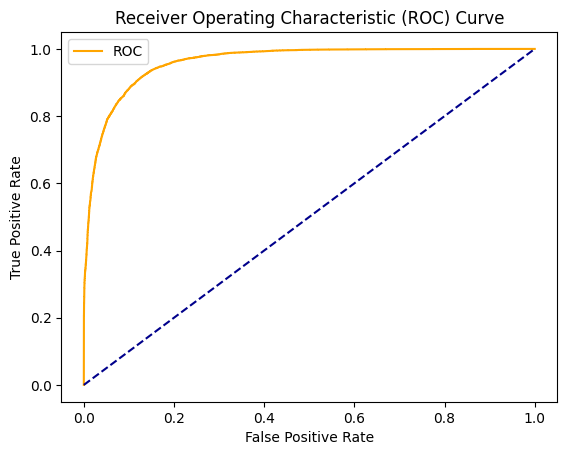

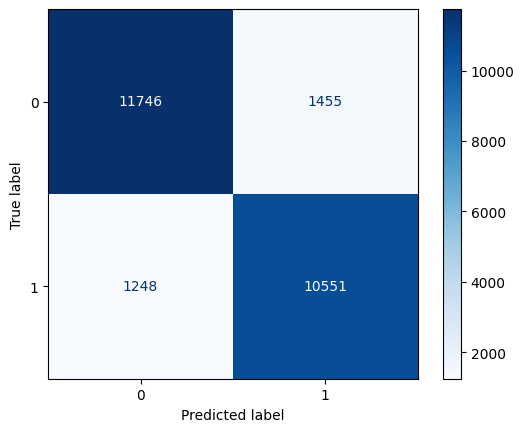

Estadisticas para el modelo: LightGBM
Sensibilidad: 0.8942283244342741
Especificidad: 0.8897810771911219
Exactitud balanceada: 0.892004700812698
Precision: 0.8788105947026487
Recuperación: 0.8942283244342741
F1-score: 0.8864524259609327
Accuracy: 0.89188


In [23]:
# Light GBM
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 500, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, ttt_lgb , ttp_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test, "LightGBM")

### XGBClassifier

Árbol de desición de XGBoost

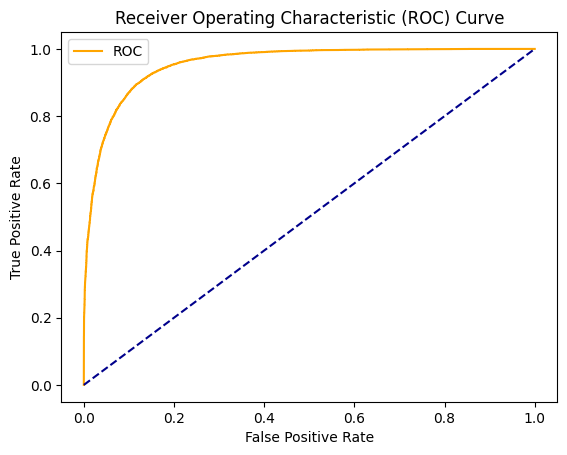

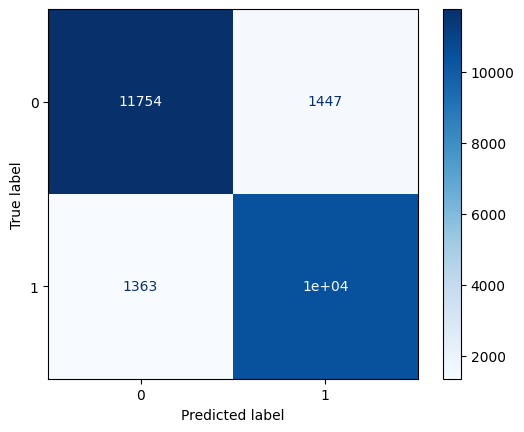

Estadisticas para el modelo: XGB
Sensibilidad: 0.884481735740317
Especificidad: 0.8903870918869783
Exactitud balanceada: 0.8874344138136476
Precision: 0.8782294033493225
Recuperación: 0.884481735740317
F1-score: 0.8813444810404527
Accuracy: 0.8876


In [24]:
# XGBoost
params_xgb = {'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 500, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, ttt_xgb , ttp_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test, "XGB")

## Comparación de modelos

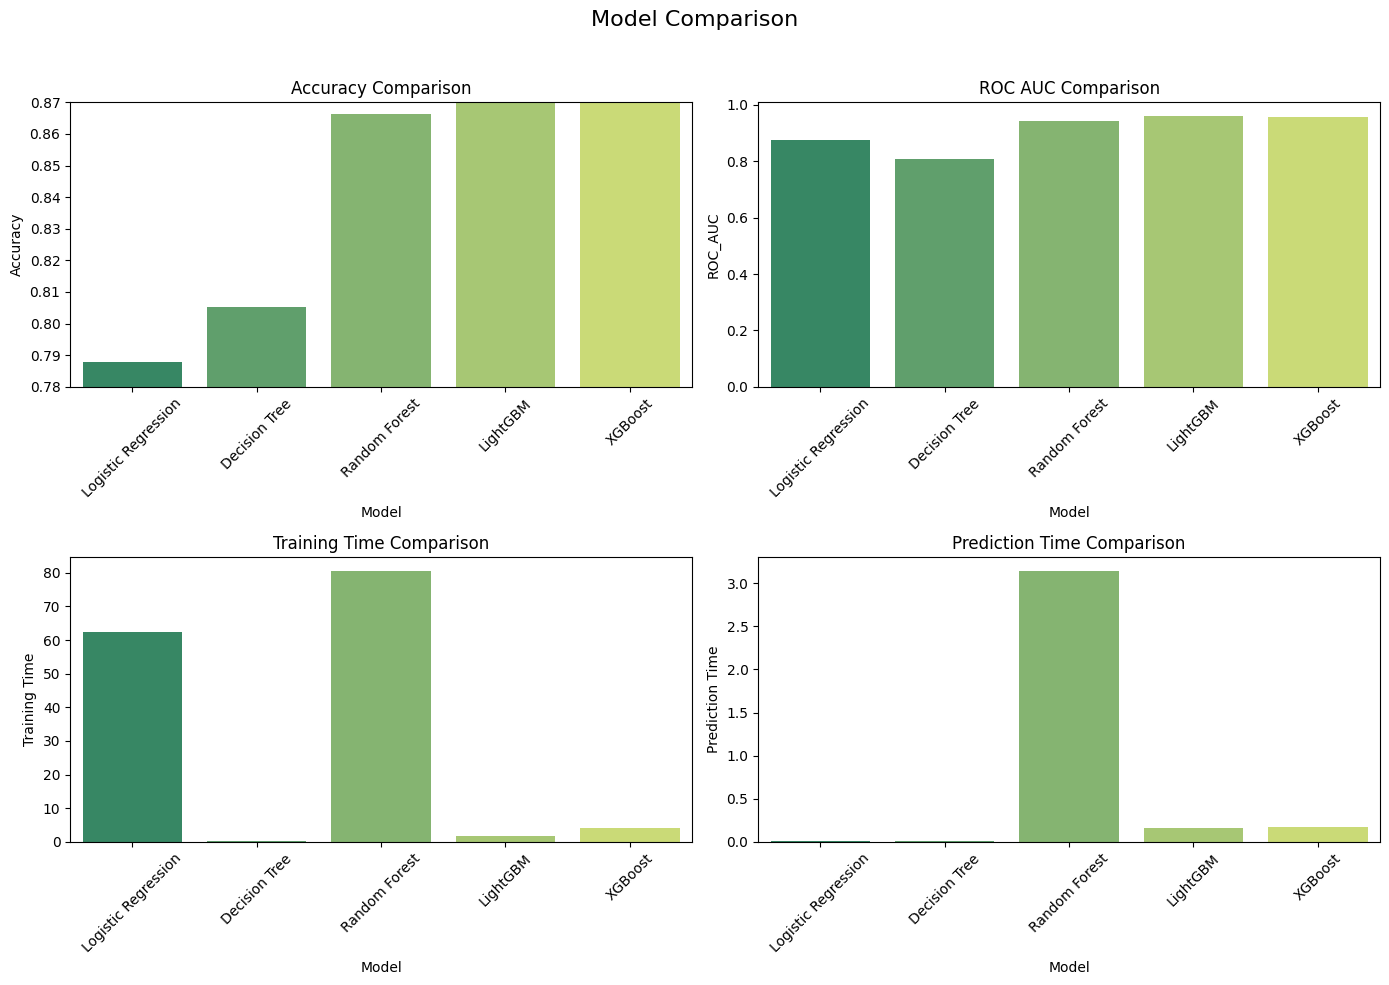

In [25]:
# Define the scores and time taken for each model
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_lgb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_lgb, roc_auc_xgb]
ttt = [ttt_lr, ttt_dt, ttt_rf, ttt_lgb, ttt_xgb]
ttp = [ttp_lr, ttp_dt, ttp_rf, ttp_lgb, ttp_xgb]

# Define the model names
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost']

# Create a dataframe for plotting
model_data = {
    'Model': models,
    'Accuracy': accuracy_scores,
    'ROC_AUC': roc_auc_scores,
    'Training Time': ttt,
    'Prediction Time': ttp
}
data = pd.DataFrame(model_data)

# Set up the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Comparison', fontsize=16)

# Define the color palette
palette = 'summer'

# Plot Accuracy
sns.barplot(x='Model', y='Accuracy', data=data, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylim(0.78, 0.87)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot ROC_AUC
sns.barplot(x='Model', y='ROC_AUC', data=data, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title('ROC AUC Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot Training Time
sns.barplot(x='Model', y='Training Time', data=data, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot Prediction Time
sns.barplot(x='Model', y='Prediction Time', data=data, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title('Prediction Time Comparison')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**NOTA:** A partir del grafico anterior podemos ver como XGBoost es uno de los modelos que mejor performa. A partir de este vamos a trabajar mejorando nuestro modelo.

# Entrenamiento del modelo final

### Creacion de hiperparametros

In [26]:
# escala de targets negativos para scale_pos_weight
negativos = sum(y==0)
positivos = sum(y==1)
scale = negativos / positivos
scale

1.1625362224817266

In [27]:
# peso de los true targets para base_score
peso = y.mean()
peso

0.46242

In [36]:
### Parametria a explorar (hiperparametros).
dictParams = {'max_depth':[3, 10, 1],
    'learning_rate':[0.07, 0.1, 0.15, 0.2],
    #'n_estimators':[200,400,600],
    #'silent':[True],
    'objective':['binary:logistic'],
    'booster': ['gbtree'],
    'gamma':[0, 1, 2],
    'min_child_weight':[0],
    'max_delta_step':[0],
    'subsample':[0.7, 0.3],
    'colsample_bytree':[0.7,0.5],
    'colsample_bylevel':[0.7,0.5],
    'reg_alpha':[0,0.1,0.5, 0.05],
    'reg_lambda':[1,0.8,0.3, 1.2],
    'scale_pos_weight':[scale, 1, 2, 5],
    #'num_leaves':[5,20,60,150]
    'base_score': [peso, 0.1, 0.5]
    }

In [37]:
semilla = 180185     
model = xgb.XGBClassifier()

### Entrenamiento con CV

In [40]:
# La busqueda Halving ajusta dinámicamente los recursos según los resultados
search = HalvingRandomSearchCV(model,
                                dictParams,
                                resource='n_estimators',
                                max_resources=400,
                                min_resources=100 // 4,
                                factor=2,
                                cv = 5,
                                random_state=0,
                                verbose=1)

**Nota**: !pip install scikit-learn==1.3.1 to avoid this error> https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 25
max_resources_: 400
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 16
n_resources: 25
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 8
n_resources: 50
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 4
n_resources: 100
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 200
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 4
n_candidates: 1
n_resources: 400
Fitting 5 folds for each of 1 candidates, totalling 5 fits


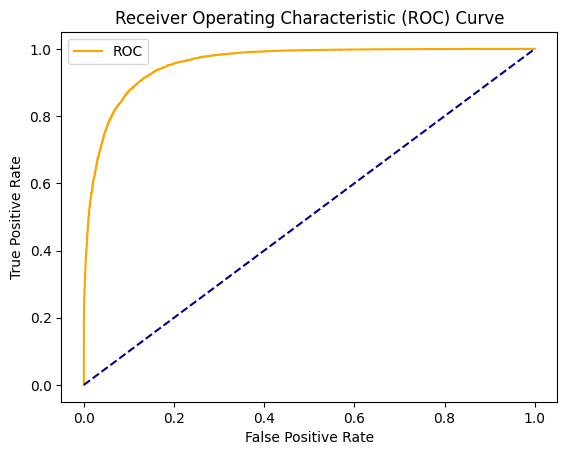

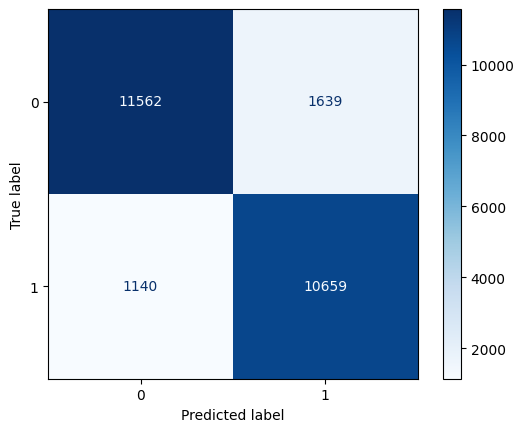

Estadisticas para el modelo: XGB
Sensibilidad: 0.9033816425120773
Especificidad: 0.8758427391864253
Exactitud balanceada: 0.8896121908492514
Precision: 0.8667262969588551
Recuperación: 0.9033816425120773
F1-score: 0.8846744408017595
Accuracy: 0.88884


In [41]:
model_search, accuracy_search, roc_auc_search, coh_kap_search, ttt_search, ttp_search = run_model(search, X_train, y_train, X_test, y_test, "XGB")

### Evaluacion

#### Metricas visuales

Trabajando con 2500 muestras

In [42]:
y_pred_prob = search.predict_proba(X_test)[:,1]
y_pred = search.predict(X_test)

In [43]:
# vamos a graficar un subset random 
if len(y_test) <= 2500:
    y_graph = y_test
else:
    y_graph = y_test.sample(2500)

# Convertir y_pred_prob a una pd.Series si es un array de numpy
if isinstance(y_pred_prob, np.ndarray):
    y_pred_prob = pd.Series(y_pred_prob, index=y_test.index)
    
y_test_g = y_test.loc[y_graph.index]
y_pred_prob_g = y_pred_prob.loc[y_graph.index]

In [46]:
#seleccion del thr usando la g-mean
fpr, tpr, thresholds = roc_curve(y_test_g, y_pred_prob_g)
prs, res, thresholds_prerec  = precision_recall_curve(y_test_g, y_pred_prob_g)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
thr = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.558530, G-Mean=0.896


In [48]:
# aditional metrics
aucroc = auc(fpr, tpr) 
aucpr = auc(res, prs) 
ap = average_precision_score(y_test, y_pred_prob)
y_proportion = sum(y_test)/len(y_test)

##### Curvas ROC y Presicion-Recall

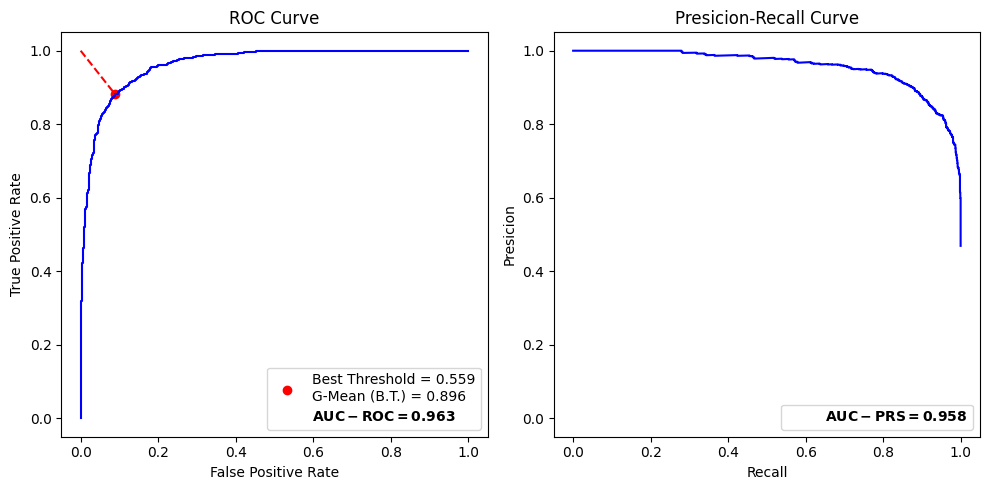

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Primer subplot
ax1.plot(fpr, tpr, color='blue')
ax1.scatter(fpr[np.argmax(gmeans)], tpr[np.argmax(gmeans)], marker='o', color='red',
            label='Best Threshold = %.3f\nG-Mean (B.T.) = %.3f' % (thresholds[np.argmax(gmeans)], gmeans[np.argmax(gmeans)]))
ax1.plot([0, fpr[np.argmax(gmeans)]], [1, tpr[np.argmax(gmeans)]], 'r--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')

# Añadir la métrica AUC - ROC a la leyenda
handles, labels = ax1.get_legend_handles_labels()
handles.append(plt.Line2D([], [], linestyle='-', color='none', label=r'$\bf{AUC - ROC = %.3f}$' % aucroc))
ax1.legend(handles=handles, loc='lower right')

# Segundo subplot
ax2.plot(res, prs, color='blue')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Presicion')
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_title('Presicion-Recall Curve')

# Añadir la métrica AUC - PRS a la leyenda
handles2, labels2 = ax2.get_legend_handles_labels()
handles2.append(plt.Line2D([], [], linestyle='-', color='none', label=r'$\bf{AUC - PRS = %.3f}$' % aucpr))
ax2.legend(handles=handles2, loc='lower right')

plt.tight_layout()
plt.show()

#print("AUC - ROC:", aucroc)
#print("AUC - PRS:", aucpr)


##### Matriz de confusión
Para el thr elegido.

In [50]:
# Confusion Matrix
cm = confusion_matrix(y_test, (y_pred_prob > thr)*1)
cmat = cm / cm.sum(axis=1)[:, np.newaxis]

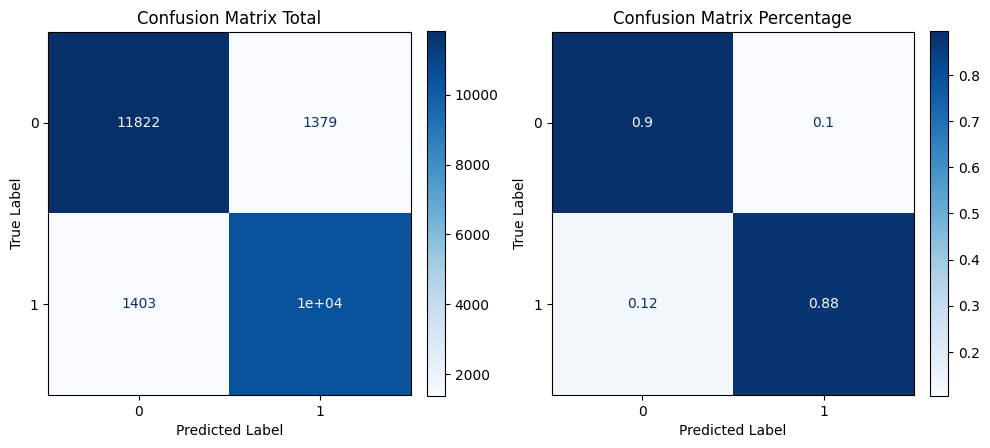

In [51]:
# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot para ax1 usando cm
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp1.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=False)  # Desactiva la barra de color predeterminada
ax1.set_title('Confusion Matrix Total')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Añadir barra de colores ajustada en altura en ax1
cax1 = disp1.ax_.figure.colorbar(disp1.im_, ax=ax1, fraction=0.046, pad=0.04)
#cax1.set_label('Counts', rotation=-90, va="bottom")

# Plot para ax2 usando cmat
disp2 = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=[0, 1])
disp2.plot(cmap=plt.cm.Blues, ax=ax2, colorbar=False)  # Desactiva la barra de color predeterminada
ax2.set_title('Confusion Matrix Percentage')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# Añadir barra de colores ajustada en altura en ax2
cax2 = disp2.ax_.figure.colorbar(disp2.im_, ax=ax2, fraction=0.046, pad=0.04)
#cax2.set_label('Counts', rotation=-90, va="bottom")

# Ajustar la disposición de los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

##### Curva de calibración y densidades de las clases

In [52]:
N = np.sum(y_test)

idxs_0 = np.random.choice(y_test[y_test==0].index, size=N)
idxs_1 = y_test[y_test==1].index
idxs = np.concatenate([idxs_0, idxs_1])

y_test_sampled, y_pred_prob_sampled = y_test[idxs], y_pred_prob[idxs]

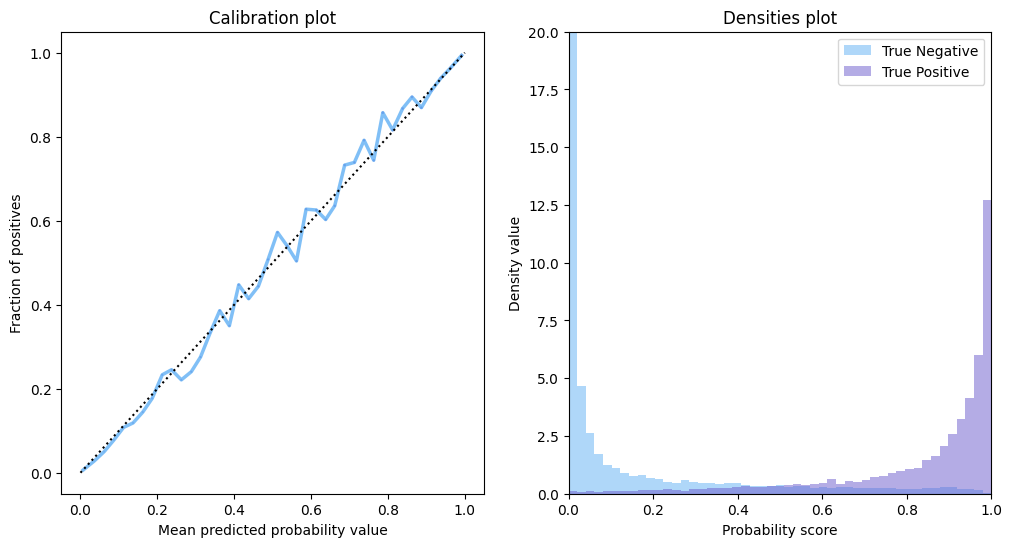

In [55]:
frac_of_pos, mean_pred_val = calibration_curve(y_test_sampled, y_pred_prob_sampled, n_bins=40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(mean_pred_val, frac_of_pos, color='slateblue', alpha=0.8, s=frac_of_pos)
ax1.plot(mean_pred_val, frac_of_pos, "-", color="#61b0f4", alpha=0.8, linewidth=2.5)
ax1.plot([0, 1], [0, 1], "k:")
#eje x: valores medios de las probabilidades predichas en cada bin
ax1.set_xlabel("Mean predicted probability value")
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.set_title('Calibration plot')

#Densities

true_pos = y_pred_prob[y_test==1]
true_neg = y_pred_prob[y_test==0]
bins = np.linspace(0, 1, 50)
ax2.hist(true_neg, bins, color="#61b0f4", alpha=0.5,density=0.5, label='True Negative')
ax2.hist(true_pos, bins, color='slateblue', alpha=0.5,density=0.5, label='True Positive')
ax2.legend(loc='upper right')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 20])
ax2.set_xlabel('Probability score')
ax2.set_ylabel('Density value')
ax2.set_title('Densities plot')

plt.show()

**Interpretación:**

- Curva de calibración:

    - El eje x representa los valores medios de las probabilidades predichas en cada bin (se configuraron 50 bines).

    - En la línea diagonal: La calibración perfecta. Por ejemplo, si el modelo predice una probabilidad de 0.7, debería corresponder a que el resultado sea positivo en el 70% de los casos.

    - Por encima de la línea diagonal: El modelo es subestimado. Predice probabilidades más bajas que los resultados reales. Por ejemplo, una probabilidad predicha de 0.4 podría corresponder a una tasa real de resultados positivos del 50%.

    - Por debajo de la línea diagonal: El modelo es sobreestimado. Predice probabilidades más altas que los resultados reales. Por ejemplo, una probabilidad predicha de 0.7 podría corresponder a una tasa real de resultados positivos del 60%.

    - **En este caso el modelo está calibrado.**

- Gráfico de densidades:

    - En este caso hay una buena separación de las funciones de densidad de probabilidades. Vemos que los True Negative se acumulan hacia un score de probabilidad 0 mientras que los True Positive se acumulan sobre el 1. Por ende la moda de las densidades de las probabilidades predichas para cada clase devuelven valores coherentes. 

    - Ademas vemos que la densidad en la clase True Positive no decae de manera ideal para los score de probabilidades más bajas y de la misma manera para los True Negative. Es decir, **el modelo está performando de igual manera para predecir los True Negative y Positive.**

##### Tabla y gráfico KS

Se va a trabajar con el mismo sample de datos que el gráfico anterior y se van a utilizar 10 bines para agrupar las probabilidades predichas.

In [56]:
def ks_chart(score,target):
    """ Función para obtener la tabla de KS.
    Parámetros
    ---------- 
    score: nombre de la variable que tenga el score o probabilidad
    target: nombre de la varuable que tenga el objetivo
    ------
    Return: Tabla KS
    ------
    """ 
    data = pd.DataFrame()
    data[y_test.name] = y_test_sampled
    data['score'] = y_pred_prob_sampled
    
    data['good'] = 1 - data[target.name]
    data['bucket'] = pd.qcut(data['score'], 10, duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    agg1 = pd.DataFrame(np.round(list(grouped.min()['score']),4), columns = ['min'])
    agg1['min'] = agg1['min'].apply('{0:.3f}'.format)
    agg1['max'] = grouped.max()['score'].apply('{0:.3f}'.format)
    agg1['bads'] = grouped.sum()[target.name]
    agg1['goods'] = grouped.sum()['good']
    agg1['total'] = agg1['bads'] + agg1['goods']
    agg2 = (agg1.sort_values(by = 'min')).reset_index(drop = True)
    agg2['odds'] = (agg2['goods'] / agg2['bads']).apply('{0:.1f}'.format)
    agg2['bad_rate'] = (agg2['bads'] / agg2.total).apply('{0:.1%}'.format)
    agg2['ks'] = abs(np.round(((agg2['bads'] / data[target.name].sum()).cumsum() - (agg2['goods'] / data['good'].sum()).cumsum()), 4) * 100).apply('{0:.1f}'.format)

    # Calcular la probabilidad acumulada para los casos positivos y negativos
    agg2['cum_positive'] = agg2['goods'].cumsum() / agg2['goods'].sum()
    agg2['cum_negative'] = agg2['bads'].cumsum() / agg2['bads'].sum()

    return agg2

ks_table = ks_chart(score = y_pred_prob_sampled,target = y_test_sampled)

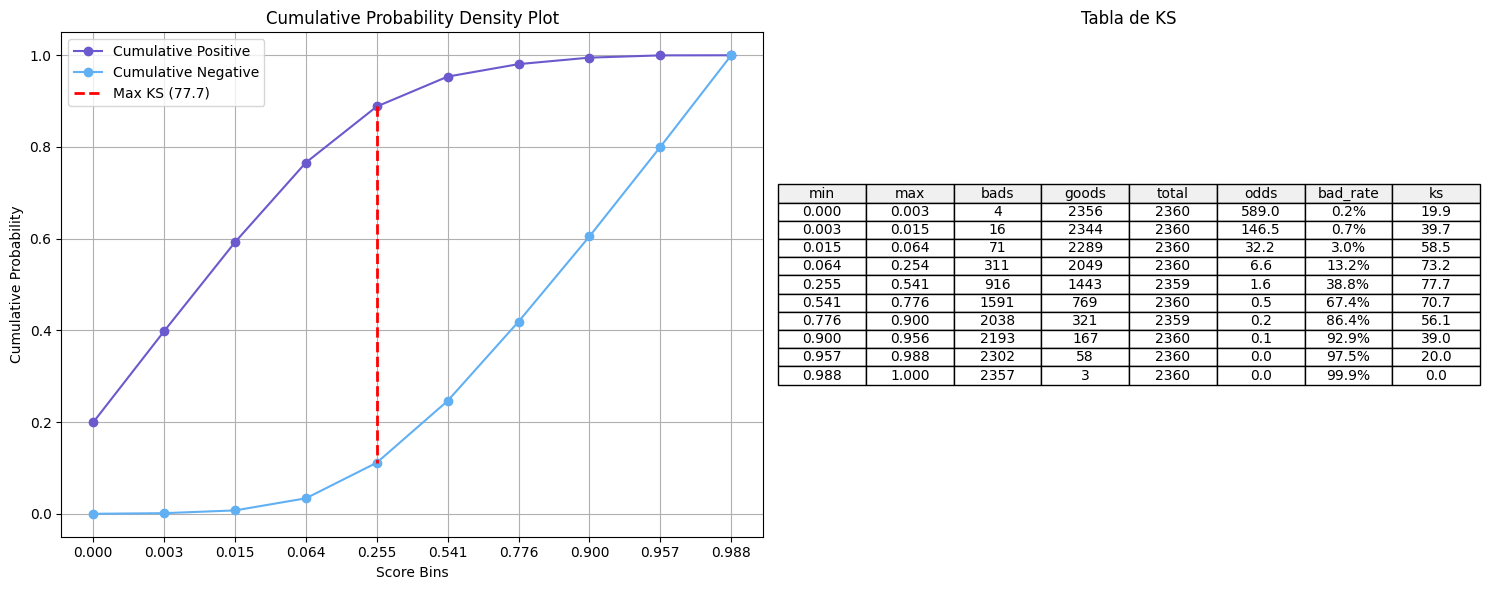

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

## FIGURA 1 - PROBABILIDAD ACUMULADA
ax1.plot(ks_table['min'], ks_table['cum_positive'], marker='o', linestyle='-', color='slateblue', label='Cumulative Positive')
ax1.plot(ks_table['min'], ks_table['cum_negative'], marker='o', linestyle='-', color='#61b0f4', label='Cumulative Negative')

# Encontrar el punto de máximo KS
max_ks_idx = ks_table['ks'].astype(float).idxmax()
# Obtener las coordenadas del punto máximo KS
max_ks_value = ks_table.loc[max_ks_idx, 'min']
max_cum_positive = ks_table.loc[max_ks_idx, 'cum_positive']
max_cum_negative = ks_table.loc[max_ks_idx, 'cum_negative']
# Línea vertical para el punto de máximo KS
ax1.plot([max_ks_value, max_ks_value], [max_cum_positive, max_cum_negative], linestyle='--', color='red', linewidth=2, label=f'Max KS ({ks_table.loc[max_ks_idx, "ks"]})')

ax1.set_xlabel('Score Bins')
ax1.set_ylabel('Cumulative Probability')
ax1.set_title('Cumulative Probability Density Plot')
ax1.legend()
ax1.grid(True)

# FIGURA 2 - Tabla de KS
# Orden deseado de las columnas
column_order = ['min', 'max', 'bads', 'goods', 'total', 'odds', 'bad_rate', 'ks']
ks_table_filtered = ks_table[column_order]

# Ocultar ejes para una visualización limpia
ax2.axis('off')
table = ax2.table(cellText=ks_table_filtered.values, colLabels=ks_table_filtered.columns, cellLoc='center', loc='center', colColours=['#f0f0f0']*len(ks_table_filtered.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)

ax2.set_title('Tabla de KS')

# Ajustar el layout general
plt.tight_layout()
plt.show()

**Interpretación:**

- Un valor de KS (Kolmogorov-Smirnov) alto indica qu el modelo es  efectivo para discriminar entre los casos positivos y negativos basándose en las probabilidades predichas. Un KS del 77.7% (valor obtenido para el sampleo actual) es generalmente considerado como un buen indicador de la capacidad predictiva del modelo en ese segmento específico. 

- Vemos que la probabilidad acumulada para la clase positiva en el primer bin es de aproximadamente un 0.2%. Lo deseable, en un modelo ideal, sería de un 0%. En la tabla de KS vemos que hay 4 targets positivos que cayeron en ese bin (columna **bads**). Sin embargo el valor obtenido esta dentro de el rango de aceptación comunmente utilizado.

---

# Conclusiones

1. Comparación de Precisión (Accuracy)

- LightGBM y XGBoost: Estos modelos han mostrado la mayor precisión, aproximadamente 0.89, lo que indica que son los más efectivos para predecir correctamente la ocurrencia de lluvia en este dataset.
- Random Forest: Presenta una precisión muy cercana a LightGBM y XGBoost, lo que también lo convierte en una opción robusta.
- Regresión Logística: Presentan una precisión ligeramente inferior, alrededor de 0.78.
- Árbol de Decisión: Este modelo muestra la menor precisión, apenas superando 0.80, lo que indica que no es muy adecuado para este problema específico.

2. Comparación de F1-score

- LightGBM, XGBoost y Bosque Aleatorio: Estos modelos destacan con valores de ROC AUC alrededor de 0.85, lo que indica una excelente capacidad discriminativa.
- Regresión Logística: Muestran una buena capacidad discriminativa, con 0.76.
- Árbol de Decisión: Similar, con un valor de 0.79.

3. Comparación de Tiempo de Entrenamiento

- Random Forest: Este modelo tiene el tiempo de entrenamiento más elevado, superando los 80 segundos, lo que puede ser prohibitivo en ciertos escenarios.
- LightGBM y XGBoost: Ambos modelos muestran tiempos de entrenamiento mucho más bajos, con LightGBM ligeramente más rápido.
- Regresión Logística: Al igual que RF, tiempo de entrenamiento muy elevado.
- Árbol de Decisión: Tiene uno de los tiempos de entrenamiento más bajos, pero dado su bajo rendimiento en precisión, F1 y ROC AUC, no es una opción recomendable.

4. Comparación de Tiempo de Predicción

- Random Forest: Presenta un tiempo de predicción elevado, cercano a 4 segundos.
- LightGBM y XGBoost: Ambos modelos tienen tiempos de predicción muy bajos, lo que los hace ideales para aplicaciones en tiempo real.
- Regresión Logística y Árbol de Decisión: Estos modelos también tienen tiempos de predicción muy bajos, siendo la Regresión Logística ligeramente más rápida.

Conclusión General Basándonos en las métricas evaluadas, LightGBM y XGBoost parecen ser las mejores opciones para este problema. Ambos modelos ofrecen una alta precisión y ROC AUC, con tiempos de entrenamiento y predicción razonables. El Random Forest, aunque también ofrece un buen rendimiento en términos de precisión y ROC AUC, su tiempo de entrenamiento es significativamente más alto, lo que puede ser una desventaja en ciertas aplicaciones. La Regresión Logística es un modelo decente, pero no alcanza el nivel de rendimiento de LightGBM y XGBoost, especialmente en términos de precisión y tiempo de predicción. El Árbol de Decisión, debido a su baja precisión y ROC AUC no es una opción recomendada.

Finalmente pensando en un ambiente productivo, comunidad, etc. XGBoost tiene un extenso soporte y desarrollo activo que me hizo inclinarlo como el mejor candidato para el problema.
